Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [40]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import math


In [23]:
def displayTrainCurves(steps, train_loss, train_acc, val_acc):
    f = plt.figure()
    f.add_subplot(2, 1, 1)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.plot(steps, train_loss, 'ro-')
    f.add_subplot(2, 1, 2)
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.plot(steps, train_acc, 'go-', steps, val_acc, 'ro-')
    plt.show()

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [24]:
batch_size = 128
beta = 0.001

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  #Regularization
  reg = tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases)
  loss += beta * reg
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Initialized
Minibatch loss at step 0: 20.461185
Minibatch accuracy: 10.9%
Validation accuracy: 11.6%
Minibatch loss at step 500: 2.491308
Minibatch accuracy: 80.5%
Validation accuracy: 75.8%
Minibatch loss at step 1000: 1.750917
Minibatch accuracy: 78.1%
Validation accuracy: 78.3%
Minibatch loss at step 1500: 0.932212
Minibatch accuracy: 83.6%
Validation accuracy: 79.8%
Minibatch loss at step 2000: 0.824731
Minibatch accuracy: 86.7%
Validation accuracy: 80.3%
Minibatch loss at step 2500: 0.849790
Minibatch accuracy: 78.9%
Validation accuracy: 81.4%
Minibatch loss at step 3000: 0.789921
Minibatch accuracy: 82.0%
Validation accuracy: 81.9%
Test accuracy: 89.1%


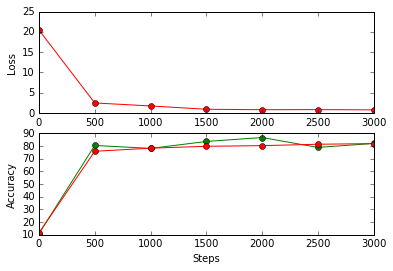

In [26]:
num_steps = 3001
steps = []
train_loss = []
train_acc = []
val_acc = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      t_acc = accuracy(predictions, batch_labels)
      v_acc = accuracy(valid_prediction.eval(), valid_labels)
      print("Minibatch accuracy: %.1f%%" % t_acc)
      print("Validation accuracy: %.1f%%" % v_acc)
      steps += [step]
      train_loss += [l]
      train_acc += [t_acc]
      val_acc += [v_acc]
      
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  displayTrainCurves(steps, train_loss, train_acc, val_acc)

In [27]:
batch_size = 128
hidden_units = 1024
beta = 0.001

graph2 = tf.Graph()
with graph2.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_units]))
  biases1 = tf.Variable(tf.zeros([hidden_units]))
  weights2 = tf.Variable(
    tf.truncated_normal([hidden_units, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(hidden1, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

  #Regularization
  reg = tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) 
  loss += beta * reg
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1), weights2) + biases2)
        
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1), weights2) + biases2)

Initialized
Minibatch loss at step 0: 680.014771
Minibatch accuracy: 7.0%
Validation accuracy: 23.1%
Minibatch loss at step 500: 200.052414
Minibatch accuracy: 80.5%
Validation accuracy: 79.6%
Minibatch loss at step 1000: 115.250061
Minibatch accuracy: 78.9%
Validation accuracy: 82.2%
Minibatch loss at step 1500: 68.674202
Minibatch accuracy: 89.8%
Validation accuracy: 82.9%
Minibatch loss at step 2000: 41.384598
Minibatch accuracy: 88.3%
Validation accuracy: 84.4%
Minibatch loss at step 2500: 25.155018
Minibatch accuracy: 89.1%
Validation accuracy: 85.4%
Minibatch loss at step 3000: 15.523691
Minibatch accuracy: 87.5%
Validation accuracy: 86.3%
Test accuracy: 93.0%


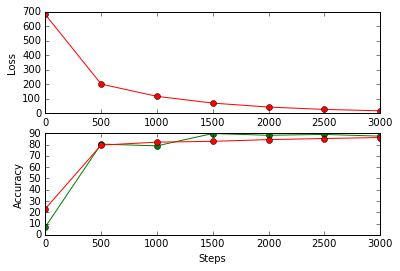

In [28]:
num_steps = 3001
steps = []
train_loss = []
train_acc = []
val_acc = []

with tf.Session(graph=graph2) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      t_acc = accuracy(predictions, batch_labels)
      v_acc = accuracy(valid_prediction.eval(), valid_labels)
      print("Minibatch accuracy: %.1f%%" % t_acc)
      print("Validation accuracy: %.1f%%" % v_acc)
      steps += [step]
      train_loss += [l]
      train_acc += [t_acc]
      val_acc += [v_acc]
      
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  displayTrainCurves(steps, train_loss, train_acc, val_acc)

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

Initialized
Minibatch loss at step 0: 556.039246
Minibatch accuracy: 13.3%
Validation accuracy: 21.1%
Minibatch loss at step 500: 190.794678
Minibatch accuracy: 100.0%
Validation accuracy: 75.9%
Minibatch loss at step 1000: 115.709221
Minibatch accuracy: 100.0%
Validation accuracy: 75.8%
Minibatch loss at step 1500: 70.172165
Minibatch accuracy: 100.0%
Validation accuracy: 75.8%
Minibatch loss at step 2000: 42.556126
Minibatch accuracy: 100.0%
Validation accuracy: 75.7%
Minibatch loss at step 2500: 25.808617
Minibatch accuracy: 100.0%
Validation accuracy: 75.6%
Minibatch loss at step 3000: 15.652422
Minibatch accuracy: 100.0%
Validation accuracy: 75.7%
Test accuracy: 82.7%


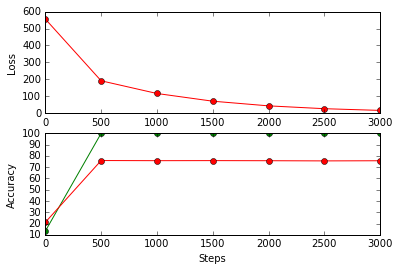

In [29]:
num_steps = 3001
steps = []
train_loss = []
train_acc = []
val_acc = []


with tf.Session(graph=graph2) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset to induce overfitting
    offset = (step * batch_size) % (4 * batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      t_acc = accuracy(predictions, batch_labels)
      v_acc = accuracy(valid_prediction.eval(), valid_labels)
      print("Minibatch accuracy: %.1f%%" % t_acc)
      print("Validation accuracy: %.1f%%" % v_acc)
      steps += [step]
      train_loss += [l]
      train_acc += [t_acc]
      val_acc += [v_acc]
      
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  displayTrainCurves(steps, train_loss, train_acc, val_acc)

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [30]:
batch_size = 128
hidden_units = 1024
beta = 0.001

graph3 = tf.Graph()
with graph3.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_units]))
  biases1 = tf.Variable(tf.zeros([hidden_units]))
  weights2 = tf.Variable(
    tf.truncated_normal([hidden_units, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  hidden1_dropout = tf.nn.dropout(hidden1, 0.5)
  logits = tf.matmul(hidden1, weights2) + biases2
  logits_dropout = tf.matmul(hidden1_dropout, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits_dropout, tf_train_labels))

  #Regularization
  reg = tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) 
  loss += beta * reg
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1), weights2) + biases2)
        
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1), weights2) + biases2)

Initialized
Minibatch loss at step 0: 741.163574
Minibatch accuracy: 15.6%
Validation accuracy: 32.8%
Minibatch loss at step 500: 191.488342
Minibatch accuracy: 100.0%
Validation accuracy: 79.0%
Minibatch loss at step 1000: 116.198746
Minibatch accuracy: 100.0%
Validation accuracy: 78.9%
Minibatch loss at step 1500: 70.492378
Minibatch accuracy: 100.0%
Validation accuracy: 78.9%
Minibatch loss at step 2000: 42.756111
Minibatch accuracy: 100.0%
Validation accuracy: 79.0%
Minibatch loss at step 2500: 25.932928
Minibatch accuracy: 100.0%
Validation accuracy: 79.3%
Minibatch loss at step 3000: 15.730801
Minibatch accuracy: 100.0%
Validation accuracy: 79.1%
Test accuracy: 86.2%


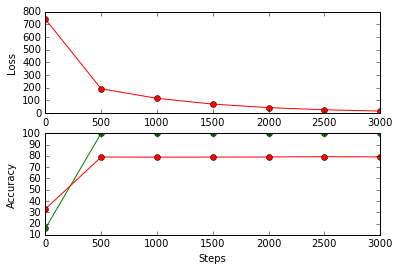

In [31]:
num_steps = 3001
steps = []
train_loss = []
train_acc = []
val_acc = []


with tf.Session(graph=graph3) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset to induce overfitting
    offset = (step * batch_size) % (4 * batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      t_acc = accuracy(predictions, batch_labels)
      v_acc = accuracy(valid_prediction.eval(), valid_labels)
      print("Minibatch accuracy: %.1f%%" % t_acc)
      print("Validation accuracy: %.1f%%" % v_acc)
      steps += [step]
      train_loss += [l]
      train_acc += [t_acc]
      val_acc += [v_acc]
      
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  displayTrainCurves(steps, train_loss, train_acc, val_acc)

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [43]:
batch_size = 128
hidden1_size = 1024
hidden2_size = 300
hidden3_size = 100
beta = 0.001
lr_init = 0.3
lr_decay = 0.95
decay_steps = 1000

def getStd(sz):
    return math.sqrt(2.0/sz)

graph4 = tf.Graph()
with graph4.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden1_size], stddev=getStd(image_size * image_size)))
  biases1 = tf.Variable(tf.zeros([hidden1_size]))
  weights2 = tf.Variable(
    tf.truncated_normal([hidden1_size, hidden2_size], stddev=getStd(hidden1_size)))
  biases2 = tf.Variable(tf.zeros([hidden2_size]))
  weights3 = tf.Variable(
    tf.truncated_normal([hidden2_size, hidden3_size], stddev=getStd(hidden2_size)))
  biases3 = tf.Variable(tf.zeros([hidden3_size]))
  weights4 = tf.Variable(
    tf.truncated_normal([hidden3_size, num_labels], stddev=getStd(hidden3_size)))
  biases4 = tf.Variable(tf.zeros([num_labels]))
  

  def getLogits(input_data, is_train):
    h1 = tf.nn.relu(tf.matmul(input_data, weights1) + biases1)
    h2 = tf.nn.relu(tf.matmul(h1, weights2) + biases2)
    h3 = tf.nn.relu(tf.matmul(h2, weights3) + biases3)
    if is_train:
      h3 = tf.nn.dropout(h3, 0.5)
    h4 = tf.matmul(h3, weights4) + biases4
    return h4

  logits_train = getLogits(tf_train_dataset, True)
  
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits_train, tf_train_labels))

  #Regularization
  reg = tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3) + tf.nn.l2_loss(weights4) 
  loss += beta * reg
  
  # Optimizer: set up a variable that's incremented once per batch and
  # controls the learning rate decay.
  global_step = tf.Variable(0)
  # Decay once per epoch, using an exponential schedule starting at 0.01.
  learning_rate = tf.train.exponential_decay(
      lr_init,                
      global_step, 
      decay_steps,          
      lr_decay,                
      staircase=True)
    
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(getLogits(tf_train_dataset, False))
  valid_prediction = tf.nn.softmax(getLogits(tf_valid_dataset, False))
  test_prediction = tf.nn.softmax(getLogits(tf_test_dataset, False))

Initialized
Minibatch loss at step 0: 3.499344
Minibatch accuracy: 14.8%
Validation accuracy: 28.5%


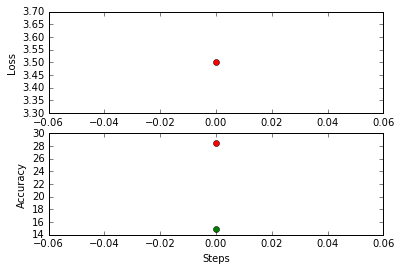

Minibatch loss at step 500: 1.213469
Minibatch accuracy: 88.3%
Validation accuracy: 85.0%


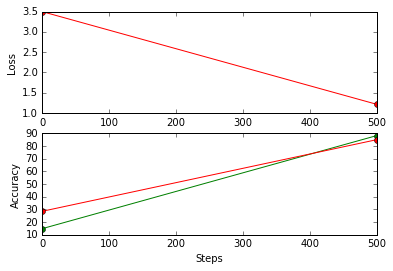

Minibatch loss at step 1000: 1.185734
Minibatch accuracy: 87.5%
Validation accuracy: 86.0%


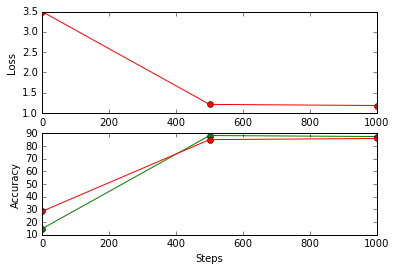

Minibatch loss at step 1500: 0.823111
Minibatch accuracy: 93.8%
Validation accuracy: 87.3%


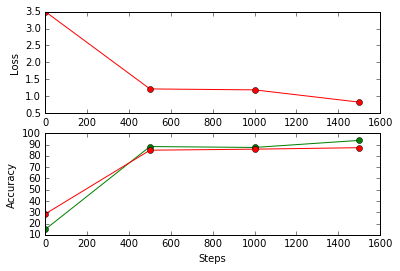

Minibatch loss at step 2000: 0.701957
Minibatch accuracy: 93.8%
Validation accuracy: 87.6%


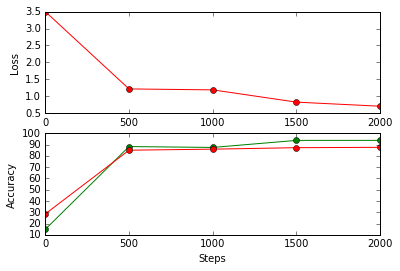

Minibatch loss at step 2500: 0.704998
Minibatch accuracy: 89.1%
Validation accuracy: 87.8%


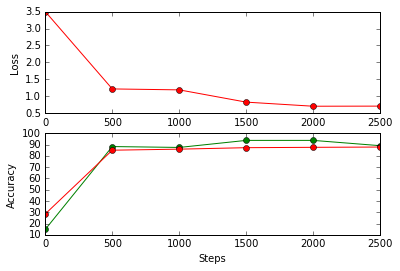

Minibatch loss at step 3000: 0.733180
Minibatch accuracy: 86.7%
Validation accuracy: 88.2%


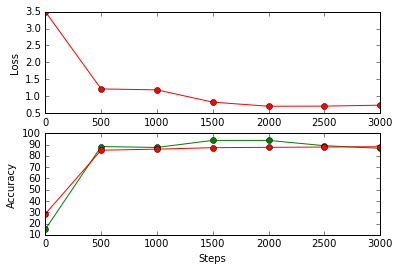

Minibatch loss at step 3500: 0.674780
Minibatch accuracy: 87.5%
Validation accuracy: 88.2%


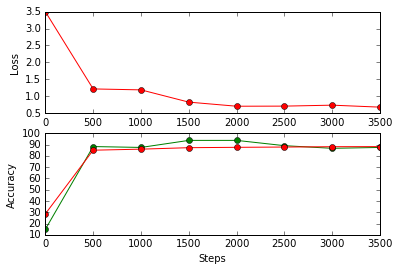

Minibatch loss at step 4000: 0.530263
Minibatch accuracy: 92.2%
Validation accuracy: 88.7%


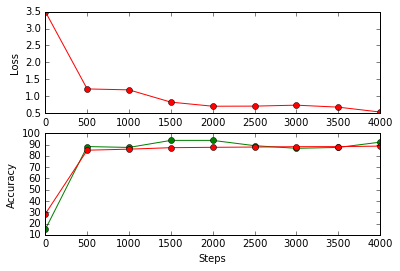

Minibatch loss at step 4500: 0.512399
Minibatch accuracy: 90.6%
Validation accuracy: 88.4%


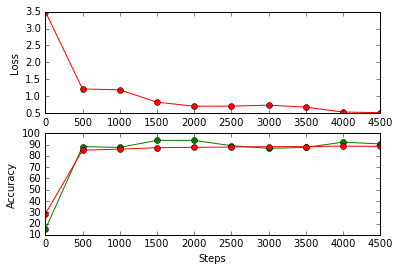

Minibatch loss at step 5000: 0.535455
Minibatch accuracy: 89.8%
Validation accuracy: 89.2%


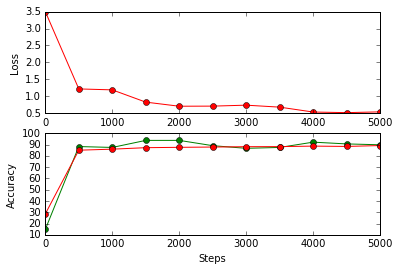

Minibatch loss at step 5500: 0.562073
Minibatch accuracy: 89.1%
Validation accuracy: 88.8%


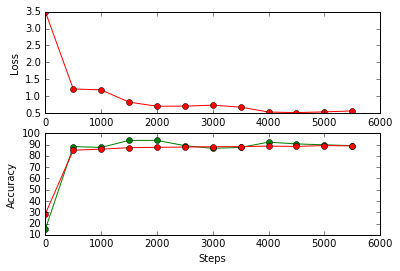

Minibatch loss at step 6000: 0.650889
Minibatch accuracy: 87.5%
Validation accuracy: 88.9%


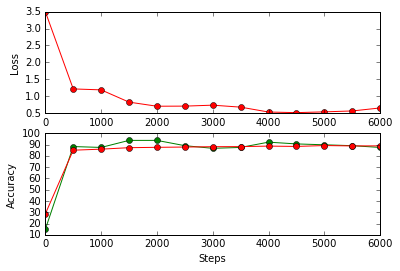

Minibatch loss at step 6500: 0.379962
Minibatch accuracy: 94.5%
Validation accuracy: 89.1%


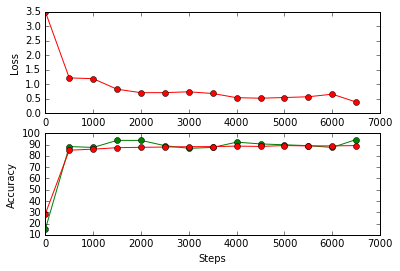

Minibatch loss at step 7000: 0.581703
Minibatch accuracy: 88.3%
Validation accuracy: 89.5%


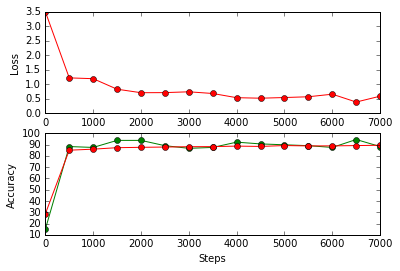

Minibatch loss at step 7500: 0.579300
Minibatch accuracy: 88.3%
Validation accuracy: 89.4%


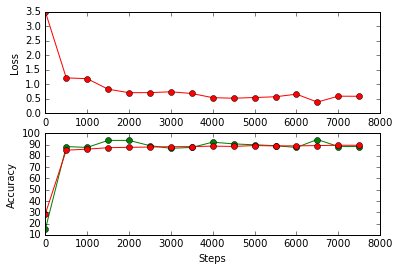

Minibatch loss at step 8000: 0.644788
Minibatch accuracy: 86.7%
Validation accuracy: 89.2%


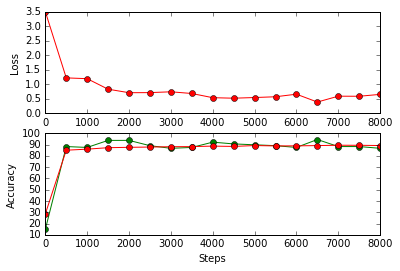

Minibatch loss at step 8500: 0.430572
Minibatch accuracy: 93.0%
Validation accuracy: 89.3%


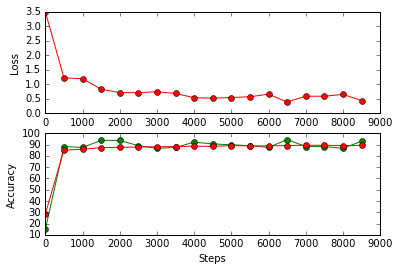

Minibatch loss at step 9000: 0.515476
Minibatch accuracy: 89.8%
Validation accuracy: 88.7%


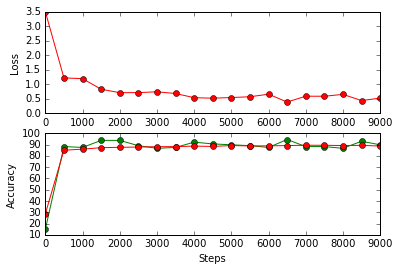

Minibatch loss at step 9500: 0.480926
Minibatch accuracy: 90.6%
Validation accuracy: 89.4%


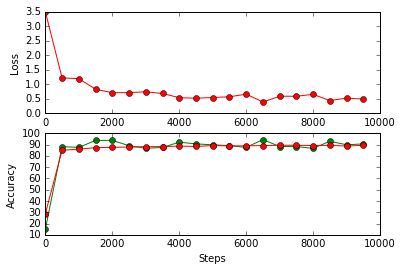

Minibatch loss at step 10000: 0.435366
Minibatch accuracy: 90.6%
Validation accuracy: 89.0%


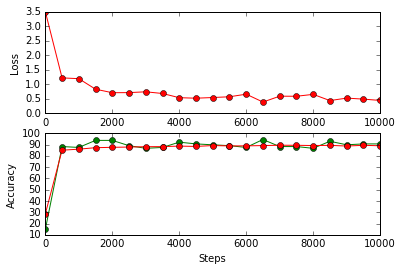

Minibatch loss at step 10500: 0.432483
Minibatch accuracy: 92.2%
Validation accuracy: 89.8%


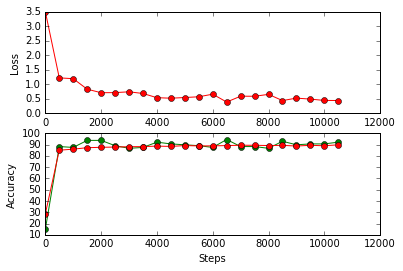

Minibatch loss at step 11000: 0.383903
Minibatch accuracy: 93.0%
Validation accuracy: 89.9%


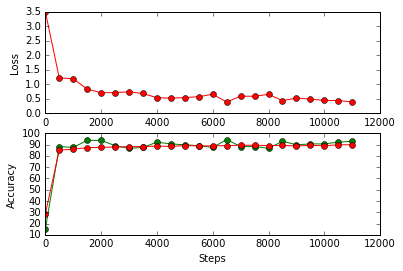

Minibatch loss at step 11500: 0.418415
Minibatch accuracy: 91.4%
Validation accuracy: 89.7%


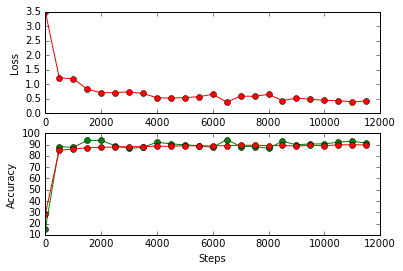

Minibatch loss at step 12000: 0.529728
Minibatch accuracy: 89.8%
Validation accuracy: 89.7%


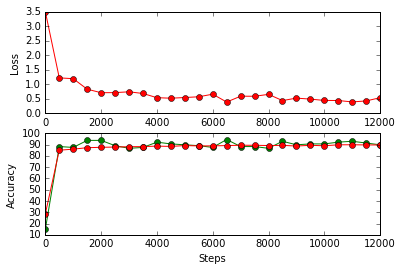

Minibatch loss at step 12500: 0.403767
Minibatch accuracy: 92.2%
Validation accuracy: 89.5%


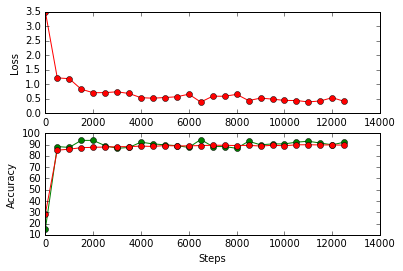

Minibatch loss at step 13000: 0.506143
Minibatch accuracy: 88.3%
Validation accuracy: 89.7%


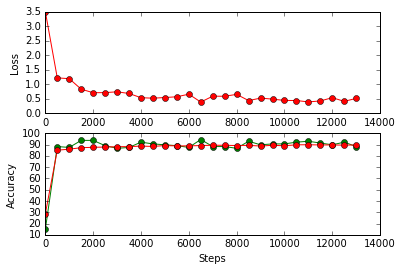

Minibatch loss at step 13500: 0.435711
Minibatch accuracy: 91.4%
Validation accuracy: 88.9%


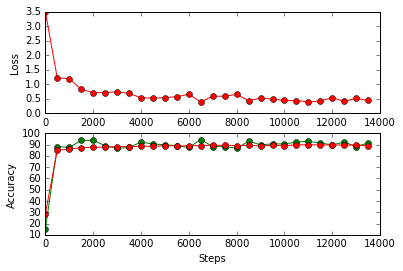

Minibatch loss at step 14000: 0.467258
Minibatch accuracy: 93.0%
Validation accuracy: 89.7%


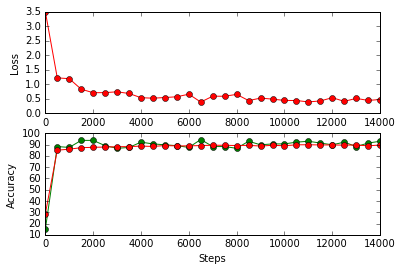

Minibatch loss at step 14500: 0.569445
Minibatch accuracy: 87.5%
Validation accuracy: 89.9%


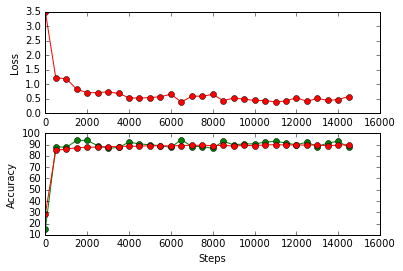

Minibatch loss at step 15000: 0.451837
Minibatch accuracy: 89.8%
Validation accuracy: 90.2%


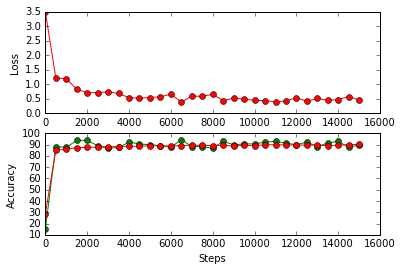

Minibatch loss at step 15500: 0.462719
Minibatch accuracy: 91.4%
Validation accuracy: 90.0%


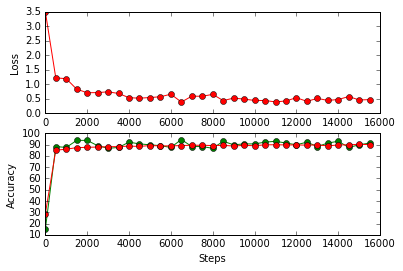

Minibatch loss at step 16000: 0.424221
Minibatch accuracy: 93.0%
Validation accuracy: 89.8%


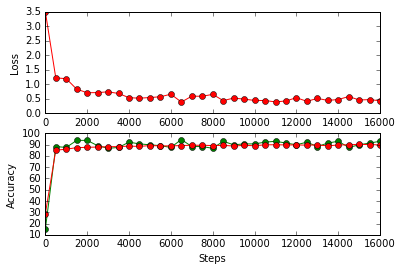

Minibatch loss at step 16500: 0.327149
Minibatch accuracy: 95.3%
Validation accuracy: 89.8%


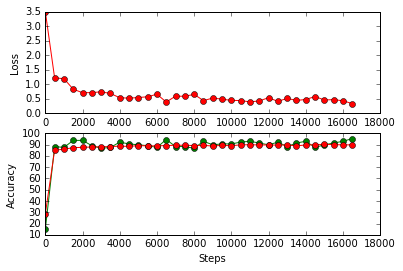

Minibatch loss at step 17000: 0.424795
Minibatch accuracy: 89.1%
Validation accuracy: 89.5%


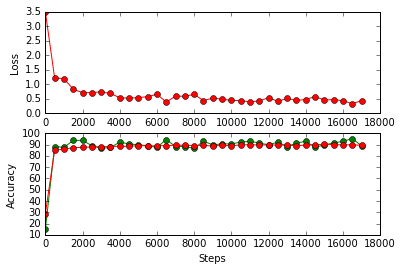

Minibatch loss at step 17500: 0.243652
Minibatch accuracy: 98.4%
Validation accuracy: 90.5%


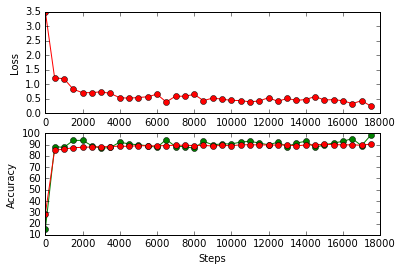

Minibatch loss at step 18000: 0.328369
Minibatch accuracy: 95.3%
Validation accuracy: 90.1%


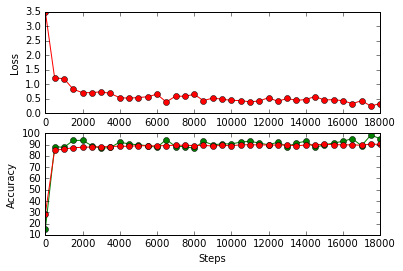

Minibatch loss at step 18500: 0.375052
Minibatch accuracy: 91.4%
Validation accuracy: 90.1%


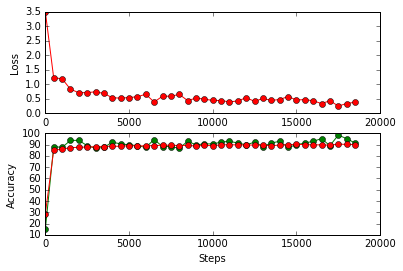

Minibatch loss at step 19000: 0.317183
Minibatch accuracy: 95.3%
Validation accuracy: 90.0%


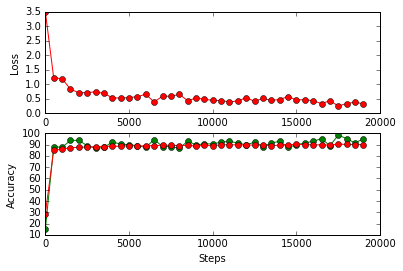

Minibatch loss at step 19500: 0.385134
Minibatch accuracy: 95.3%
Validation accuracy: 90.3%


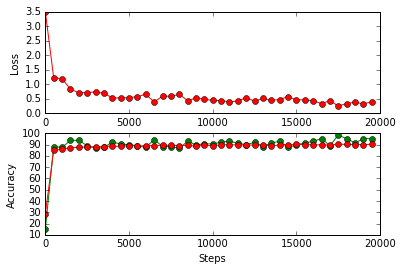

Minibatch loss at step 20000: 0.511243
Minibatch accuracy: 88.3%
Validation accuracy: 90.2%


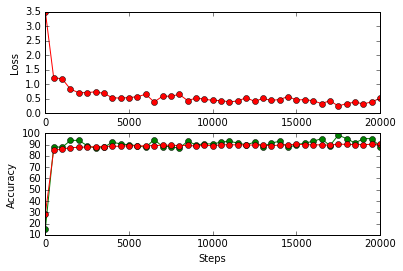

Minibatch loss at step 20500: 0.381121
Minibatch accuracy: 93.8%
Validation accuracy: 89.9%


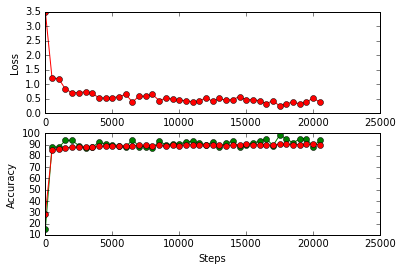

Minibatch loss at step 21000: 0.360970
Minibatch accuracy: 94.5%
Validation accuracy: 90.1%


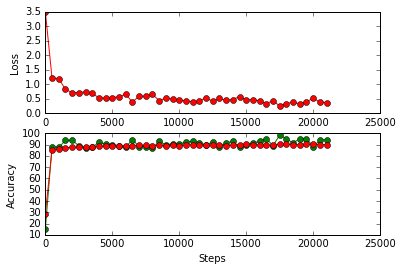

Minibatch loss at step 21500: 0.262954
Minibatch accuracy: 98.4%
Validation accuracy: 90.5%


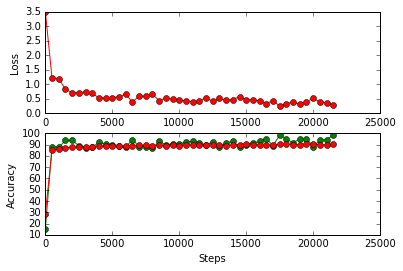

Minibatch loss at step 22000: 0.295851
Minibatch accuracy: 96.9%
Validation accuracy: 90.3%


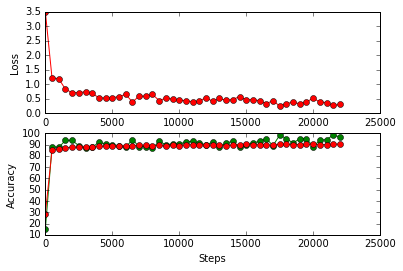

Minibatch loss at step 22500: 0.334406
Minibatch accuracy: 96.1%
Validation accuracy: 90.4%


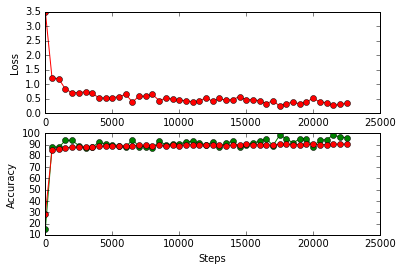

Minibatch loss at step 23000: 0.367639
Minibatch accuracy: 93.0%
Validation accuracy: 90.7%


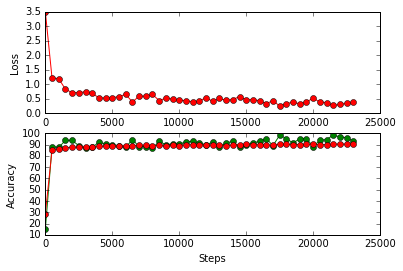

Minibatch loss at step 23500: 0.308625
Minibatch accuracy: 94.5%
Validation accuracy: 90.4%


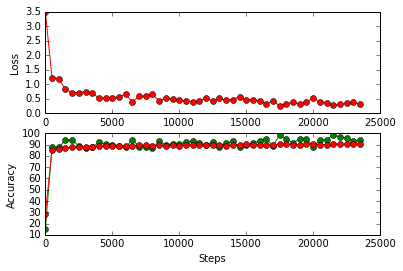

Minibatch loss at step 24000: 0.320994
Minibatch accuracy: 95.3%
Validation accuracy: 90.4%


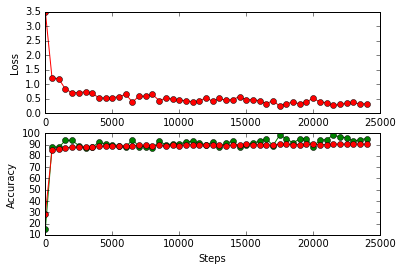

Minibatch loss at step 24500: 0.447017
Minibatch accuracy: 93.0%
Validation accuracy: 90.1%


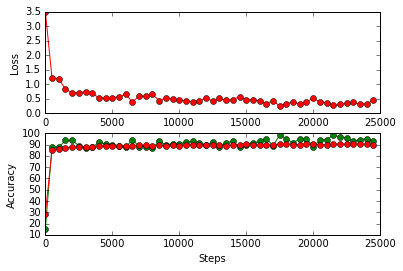

Minibatch loss at step 25000: 0.325766
Minibatch accuracy: 94.5%
Validation accuracy: 90.2%


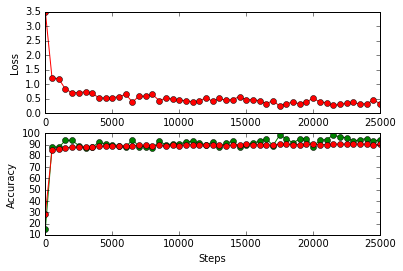

Minibatch loss at step 25500: 0.371652
Minibatch accuracy: 94.5%
Validation accuracy: 90.4%


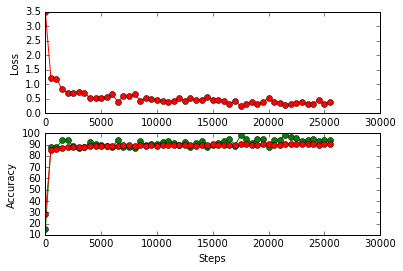

Minibatch loss at step 26000: 0.314413
Minibatch accuracy: 95.3%
Validation accuracy: 90.6%


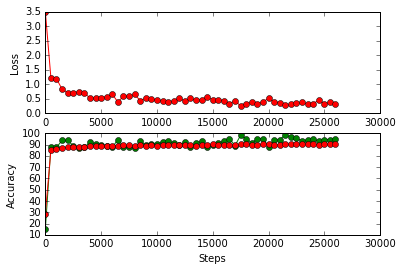

Minibatch loss at step 26500: 0.357451
Minibatch accuracy: 94.5%
Validation accuracy: 90.7%


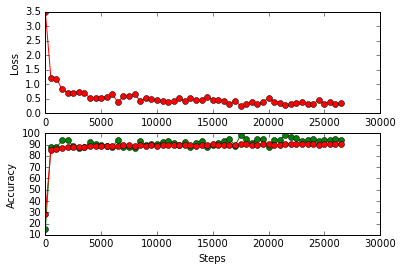

Minibatch loss at step 27000: 0.418371
Minibatch accuracy: 93.8%
Validation accuracy: 90.3%


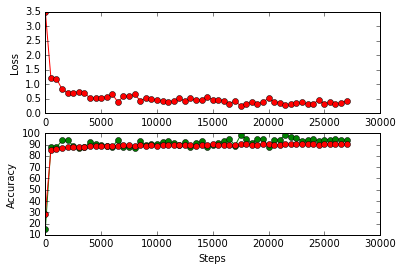

Minibatch loss at step 27500: 0.459749
Minibatch accuracy: 93.0%
Validation accuracy: 90.6%


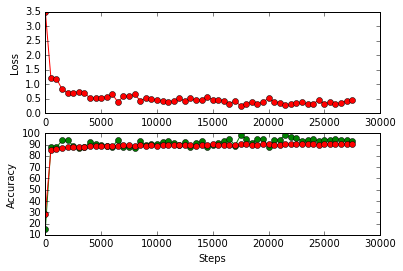

Minibatch loss at step 28000: 0.391392
Minibatch accuracy: 92.2%
Validation accuracy: 90.2%


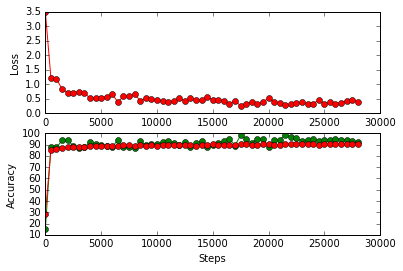

Minibatch loss at step 28500: 0.297448
Minibatch accuracy: 95.3%
Validation accuracy: 90.3%


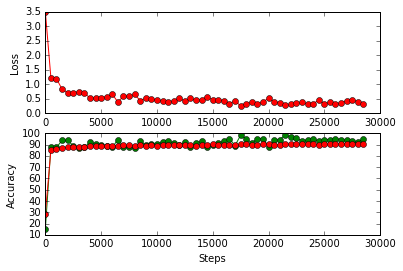

Minibatch loss at step 29000: 0.448243
Minibatch accuracy: 93.8%
Validation accuracy: 90.6%


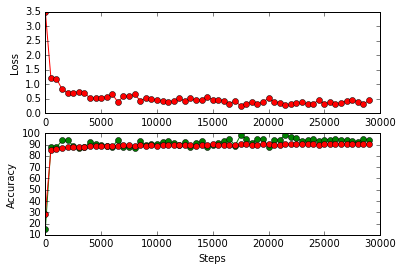

Minibatch loss at step 29500: 0.374895
Minibatch accuracy: 95.3%
Validation accuracy: 90.5%


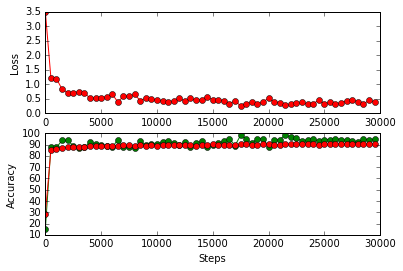

Minibatch loss at step 30000: 0.265481
Minibatch accuracy: 97.7%
Validation accuracy: 90.5%


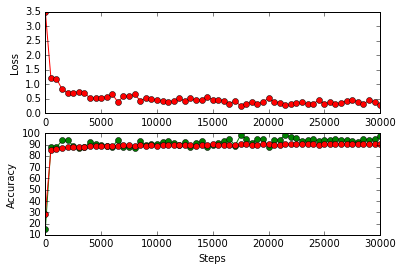

Test accuracy: 96.1%


In [45]:
num_steps = 30001
steps = []
train_loss = []
train_acc = []
val_acc = []

with tf.Session(graph=graph4) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      t_acc = accuracy(predictions, batch_labels)
      v_acc = accuracy(valid_prediction.eval(), valid_labels)
      print("Minibatch accuracy: %.1f%%" % t_acc)
      print("Validation accuracy: %.1f%%" % v_acc)
      steps += [step]
      train_loss += [l]
      train_acc += [t_acc]
      val_acc += [v_acc]
      displayTrainCurves(steps, train_loss, train_acc, val_acc)
      
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  